In [2]:
import tensorflow as tf
import numpy as np
from matplotlib import cm
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import sys

# Just to reset the graph such that it is possible to rerun this in a
# Jupyter cell without resetting the whole kernel.
tf.reset_default_graph()
# Set a seed to ensure getting the same results from every run
tf.set_random_seed(4155)

Nx = 10
x_np = np.linspace(0,1,Nx)
Nt = 10
t_np = np.linspace(0,0.1,Nt)

X,T = np.meshgrid(x_np, t_np)
x = X.ravel()
t = T.ravel()
## The construction phase
zeros = tf.reshape(tf.convert_to_tensor(np.zeros(x.shape)),shape=(-1,1))
x = tf.reshape(tf.convert_to_tensor(x),shape=(-1,1))
t = tf.reshape(tf.convert_to_tensor(t),shape=(-1,1))
points = tf.concat([x,t],1)
num_iter = 100000
num_hidden_neurons = [90]
X = tf.convert_to_tensor(X)
T = tf.convert_to_tensor(T)

with tf.variable_scope('dnn'):
    num_hidden_layers = np.size(num_hidden_neurons)
    previous_layer = points
    for l in range(num_hidden_layers):
        current_layer = tf.layers.dense(previous_layer, num_hidden_neurons[l],activation=tf.nn.sigmoid)
        previous_layer = current_layer
    dnn_output = tf.layers.dense(previous_layer, 1)
    
def u(x):
    return tf.sin(np.pi*x)

with tf.name_scope('loss'):
    g_trial = (1-t)*u(x) + x*(1-x)*t*dnn_output
    g_trial_dt = tf.gradients(g_trial,t)
    g_trial_d2x = tf.gradients(tf.gradients(g_trial,x),x)
    loss = tf.losses.mean_squared_error(zeros, g_trial_dt[0] - g_trial_d2x[0])
    
learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    traning_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
g_analytic = tf.exp(-np.pi**2*t)*tf.sin(np.pi*x)
g_dnn = None

## The execution phase
with tf.Session() as sess:
    init.run()
    for i in range(num_iter):
        sess.run(traning_op)
        # If one desires to see how the cost function behaves during training
        #if i % 100 == 0:
        #print(loss.eval())
    g_analytic = g_analytic.eval()
    g_dnn = g_trial.eval()
    
## Compare with the analutical solution
diff = np.abs(g_analytic - g_dnn)
print('Max absolute difference between analytical solution and TensorFlow DNN = %g' % np.max(diff))
G_analytic = g_analytic.reshape((Nt,Nx))
G_dnn = g_dnn.reshape((Nt,Nx))
diff = np.abs(G_analytic - G_dnn)

Max absolute difference between analytical solution and TensorFlow DNN = 0.00687778


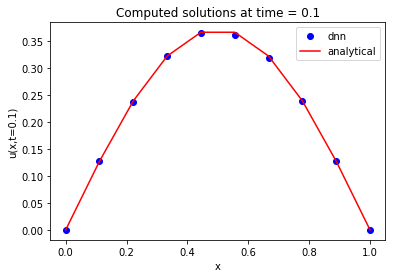

In [4]:
# Plot the slices
indx1 = 0
indx2 = int(Nt/2)
indx3 = Nt-1
t1 = t_np[indx1]
t2 = t_np[indx2]
t3 = t_np[indx3]

# Slice the results from the DNN
res1 = G_dnn[indx1,:]
res2 = G_dnn[indx2,:]
res3 = G_dnn[indx3,:]
# Slice the analytical results
res_analytical1 = G_analytic[indx1,:]
res_analytical2 = G_analytic[indx2,:]
res_analytical3 = G_analytic[indx3,:]

plt.title("Computed solutions at time = %g"%t3)
plt.plot(x_np, res3,'ob')
plt.plot(x_np,res_analytical3,'-r')
plt.legend(['dnn','analytical'])
plt.xlabel('x')
plt.ylabel('u(x,t=0.1)')
plt.show()

10
